# **TensorFlow Implementation of Fully Connected Neural Networks**

*Ming Ming Zhang*

Implement in TensorFlow a fully connected L-layer ReLU neural network for any integer $L>0$ with $L_1$ or $L_2$-regularization, dropout, batch normalization, different optimization methods and loss functions.

In [0]:
import tensorflow as tf
#print('TensorFlow version %s, # GPUs %d' % (tf.__version__, len(tf.config.experimental.list_physical_devices('GPU'))))

import numpy as np

import matplotlib.pyplot as plt

TensorFlow version 2.2.0-rc3, # GPUs 0


**1. Implementation**

In [0]:
def FCNet_TF(input_dim, hidden_dims, num_classes, reg=0.0, reg_method='L2', 
             bn=False, dropouts=None, last_activation='softmax', weight_scale=2.0):
  """
  Build a fully connected L-layer neural network for any integer L>0 with ReLU 
  activation function, and L1/L2 regularized sigmoid/softmax loss function, i.e.,
  {linear - [bn] - relu - [dropout]} * (L-1) - linear - sigmoid/softmax,
  where [bn] batch normalization and [dropout] dropout are optional.

  Inputs:
  -input_dim: integer>0 the size of input
  -hidden_dims: list of integers>0 the size of each hidden layer
  -num_classes: integer>=1 the number of classes to classify, last_activation='sigmoid' when num_classes=1
  -reg: scalar L1 or L2 regularization strength
  -reg_method: string 'L1' or 'L2' regularization
  -bn: boolean batch normalization
  -dropouts: list of scalars in [0,1] droping probability for each hidden layer, None otherwise
  -last_activation: string 'softmax' or 'sigmoid' activation function
  -weight_scale: scalar the standard deviation for random initialization of the weights

  Output:
  -model: tensorflow keras model
  """

  input_shape = (input_dim,)
  inputs = tf.keras.Input(shape=input_shape)
  X = inputs

  initializer = tf.initializers.VarianceScaling(scale=weight_scale)
  if reg_method == 'L1':
    regularizer = tf.keras.regularizers.l1(reg)
  elif reg_method == 'L2':
    regularizer = tf.keras.regularizers.l2(reg)
  for l in range(len(hidden_dims)):
    hidden_size = hidden_dims[l]
    X = tf.keras.layers.Dense(hidden_size, kernel_initializer=initializer, kernel_regularizer=regularizer)(X)
    if bn == True:
      X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation(activation='relu')(X)
    if dropouts is not None:
      dropout = dropouts[l]
      X = tf.keras.layers.Dropout(rate=dropout)(X)

  X = tf.keras.layers.Dense(num_classes, kernel_initializer=initializer, kernel_regularizer=regularizer)(X)
  if bn == True:
    X = tf.keras.layers.BatchNormalization()(X)
  if last_activation == 'softmax':
    X = tf.keras.layers.Activation(activation='softmax')(X)
  elif last_activation == 'sigmoid':
    X = tf.keras.layers.Activation(activation='sigmoid')(X)

  model = tf.keras.Model(inputs=inputs, outputs=X)

  return model

In [0]:
def train(model, data, loss='softmax', optimization='adam', lr=1e-2, batch_size=32, 
          num_epochs=1, metrics=['accuracy'], verbose=1):
  """
  Train the model.

  Inputs:
  -model: model object obtained by Tensorflow as above.
  -data: dictionary of training and validation data, i.e., X_train, X_val, y_train, y_val
  where X is numpy of shape (number of examples, size of input) and y is numpy of shape (number of examples,)
  -loss: string 'softmax' or 'sigmoid' cross-entropy function
  -optimization: string 'sgd' or 'adam'
  -lr: scalar step size (learning rate) in optimization update
  -batch_size: size of minibatches used to compute loss and gradient during training
  -num_epochs: the number of epochs to run during training
  -metrics: list of strings, i.e., 'accuracy' or 'AUC'
  -verbose: 0, 1, or 2, 0 = silent, 1 = progress bar, 2 = one line per epoch

  Outputs:
  -prints out the training process and returns the trained model.
  """

  X_train = data['X_train']
  X_val = data['X_val']
  y_train = data['y_train']
  y_val = data['y_val']

  if optimization == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
  elif optimization == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  
  if loss == 'softmax':
    loss='sparse_categorical_crossentropy'
  elif loss == 'sigmoid':
    loss='binary_crossentropy'  
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  
  return model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val), verbose=verbose)

**2. Sanity Checks**

In [0]:
# Loss checking

N, D, H1, C = 3, 100, 100, 10
X = np.random.randn(N,D)
y = np.random.randint(C, size=(N,))

num_train = N
mask = list(range(num_train))
X_train = X[mask]
y_train = y[mask]
X_val = X_train
y_val = y_train

data = {}
data['X_train'] = X_train
data['X_val'] = X_val
data['y_train'] = y_train
data['y_val'] = y_val

correct_loss = -np.log(1/C)
print('Expected loss %.3f\n' % correct_loss)

scale = 1e-3
regs = [0.0, 1e1]
for i in range(2):
   model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, reg=regs[i], reg_method='L2', weight_scale=scale)
   print('L2 reg %.1f' % regs[i])
   train(model, data)

for i in range(2):
   model = FCNet_TF(input_dim=D, hidden_dims=[H1], num_classes=C, reg=regs[i], reg_method='L1', weight_scale=scale)
   print('L1 reg %.1f' % regs[i])
   train(model, data)

Expected loss 2.303

L2 reg 0.0
1/1 [==============================] - 0s 177ms/step - loss: 2.3023 - accuracy: 0.0000e+00 - val_loss: 2.0128 - val_accuracy: 1.0000
L2 reg 10.0
1/1 [==============================] - 0s 106ms/step - loss: 3.3891 - accuracy: 0.0000e+00 - val_loss: 8.6954 - val_accuracy: 0.3333
L1 reg 0.0
1/1 [==============================] - 0s 92ms/step - loss: 2.3021 - accuracy: 0.0000e+00 - val_loss: 2.0334 - val_accuracy: 1.0000
L1 reg 10.0
1/1 [==============================] - 0s 105ms/step - loss: 286.7866 - accuracy: 0.3333 - val_loss: 817.8081 - val_accuracy: 0.3333


Epoch 1/10
1/1 [==============================] - 0s 101ms/step - loss: 2.0609 - accuracy: 0.0000e+00 - val_loss: 1.6029 - val_accuracy: 0.1250
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 1.5060 - accuracy: 0.2000 - val_loss: 1.4596 - val_accuracy: 0.1500
Epoch 3/10
1/1 [==============================] - 0s 32ms/step - loss: 1.0722 - accuracy: 0.5000 - val_loss: 1.3275 - val_accuracy: 0.2750
Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 0.7931 - accuracy: 0.5000 - val_loss: 1.2111 - val_accuracy: 0.4000
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.6165 - accuracy: 0.6000 - val_loss: 1.1117 - val_accuracy: 0.4250
Epoch 6/10
1/1 [==============================] - 0s 34ms/step - loss: 0.5133 - accuracy: 0.7000 - val_loss: 1.0214 - val_accuracy: 0.4500
Epoch 7/10
1/1 [==============================] - 0s 30ms/step - loss: 0.4659 - accuracy: 0.7000 - val_loss: 0.9373 - val_accuracy: 0.4500
Epoch 8/10
1/1 [======

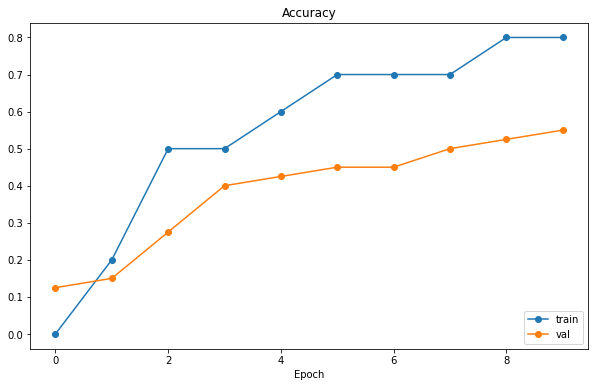

In [0]:
# Overfiting small random data

np.random.seed(123)

N, D, H1, H2, C = 50, 50, 10, 5, 1
X = np.random.randn(N,D)
y = np.random.randint(C, size=(N,))

num_train = 10
num_val = 40
mask = list(range(num_train))
X_train = X[mask]
y_train = y[mask]
mask = list(range(num_train, num_train+num_val))
X_val = X[mask]
y_val = y[mask]

data = {}
data['X_train'] = X_train
data['X_val'] = X_val
data['y_train'] = y_train
data['y_val'] = y_val

last_activation='sigmoid'
loss = 'sigmoid'
model = FCNet_TF(input_dim=D, hidden_dims=[H1,H2], num_classes=C, last_activation=last_activation)
history = train(model, data, num_epochs=10, loss=loss)

plt.title('Accuracy')
plt.plot(history.history['accuracy'], '-o', label='train')
plt.plot(history.history['val_accuracy'], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 6)
plt.show()

w/o batch norm:
Epoch 1/10
29/29 [==============================] - 0s 8ms/step - loss: 2.5204 - accuracy: 0.0978 - val_loss: 2.2795 - val_accuracy: 0.1200
Epoch 2/10
29/29 [==============================] - 0s 5ms/step - loss: 2.3036 - accuracy: 0.1778 - val_loss: 2.3119 - val_accuracy: 0.1500
Epoch 3/10
29/29 [==============================] - 0s 5ms/step - loss: 2.1349 - accuracy: 0.2456 - val_loss: 2.4426 - val_accuracy: 0.1000
Epoch 4/10
29/29 [==============================] - 0s 5ms/step - loss: 1.7778 - accuracy: 0.3444 - val_loss: 2.4559 - val_accuracy: 0.0900
Epoch 5/10
29/29 [==============================] - 0s 5ms/step - loss: 1.5542 - accuracy: 0.4889 - val_loss: 2.4253 - val_accuracy: 0.1100
Epoch 6/10
29/29 [==============================] - 0s 6ms/step - loss: 1.4169 - accuracy: 0.5689 - val_loss: 2.5194 - val_accuracy: 0.1200
Epoch 7/10
29/29 [==============================] - 0s 6ms/step - loss: 1.2169 - accuracy: 0.5922 - val_loss: 2.6840 - val_accuracy: 0.0800
Epoc

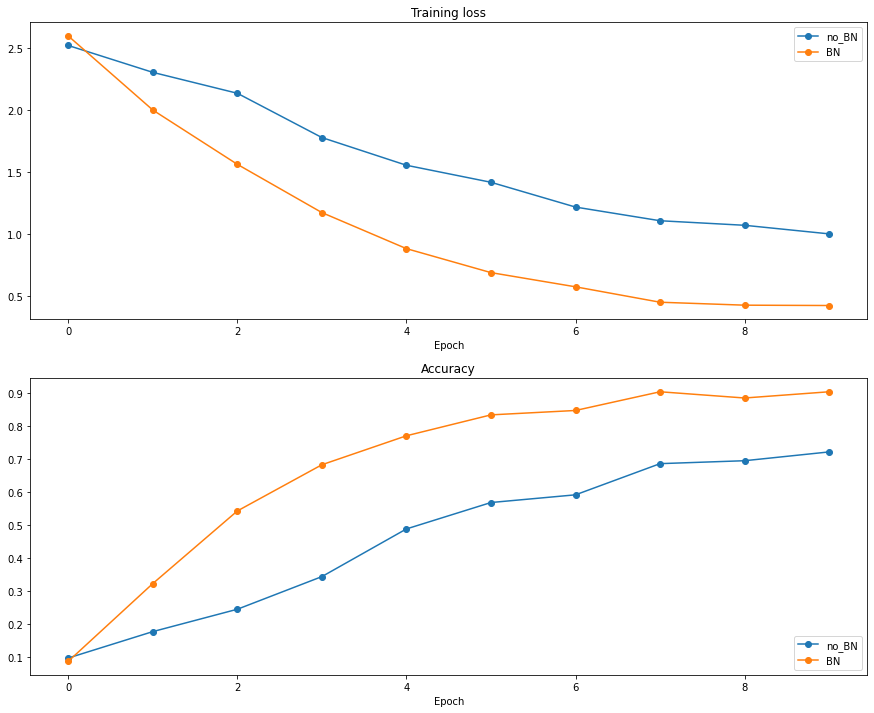

In [0]:
# Batch normalization checking

np.random.seed(123)

N, D, H1, H2, H3, H4, H5, C = 1000, 32*32*3, 100, 100, 100, 100, 100, 10
X = np.random.randn(N,D)
y = np.random.randint(C, size=(N,))

num_train = 900
num_val = 100
mask = list(range(num_train))
X_train = X[mask]
y_train = y[mask]
mask = list(range(num_train, num_train+num_val))
X_val = X[mask]
y_val = y[mask]

data = {}
data['X_train'] = X_train
data['X_val'] = X_val
data['y_train'] = y_train
data['y_val'] = y_val

lr = 1e-2
epochs = 10

print('w/o batch norm:')
no_BN_model = FCNet_TF(input_dim=D, hidden_dims=[H1,H2,H3,H4,H5], num_classes=C, bn=False)
no_BN_history = train(no_BN_model, data, num_epochs=epochs, lr=lr)

print('\nwith batch norm:')
BN_model = FCNet_TF(input_dim=D, hidden_dims=[H1,H2,H3,H4,H5], num_classes=C, bn=True)
BN_history = train(BN_model, data, num_epochs=epochs, lr=lr)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(no_BN_history.history['loss'], '-o', label='no_BN')
plt.plot(BN_history.history['loss'], '-o', label='BN')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(no_BN_history.history['accuracy'], '-o', label='no_BN')
plt.plot(BN_history.history['accuracy'], '-o', label='BN')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

w/o dropout:
Epoch 1/10
29/29 [==============================] - 0s 8ms/step - loss: 2.4480 - accuracy: 0.0867 - val_loss: 2.3596 - val_accuracy: 0.1100
Epoch 2/10
29/29 [==============================] - 0s 5ms/step - loss: 2.3052 - accuracy: 0.1500 - val_loss: 2.3079 - val_accuracy: 0.0400
Epoch 3/10
29/29 [==============================] - 0s 5ms/step - loss: 2.1489 - accuracy: 0.2211 - val_loss: 2.3304 - val_accuracy: 0.0800
Epoch 4/10
29/29 [==============================] - 0s 5ms/step - loss: 1.9156 - accuracy: 0.2922 - val_loss: 2.3178 - val_accuracy: 0.1000
Epoch 5/10
29/29 [==============================] - 0s 5ms/step - loss: 1.6265 - accuracy: 0.4267 - val_loss: 2.6306 - val_accuracy: 0.1100
Epoch 6/10
29/29 [==============================] - 0s 6ms/step - loss: 1.5686 - accuracy: 0.5067 - val_loss: 2.5505 - val_accuracy: 0.1200
Epoch 7/10
29/29 [==============================] - 0s 5ms/step - loss: 1.3783 - accuracy: 0.5722 - val_loss: 2.5482 - val_accuracy: 0.1000
Epoch 8

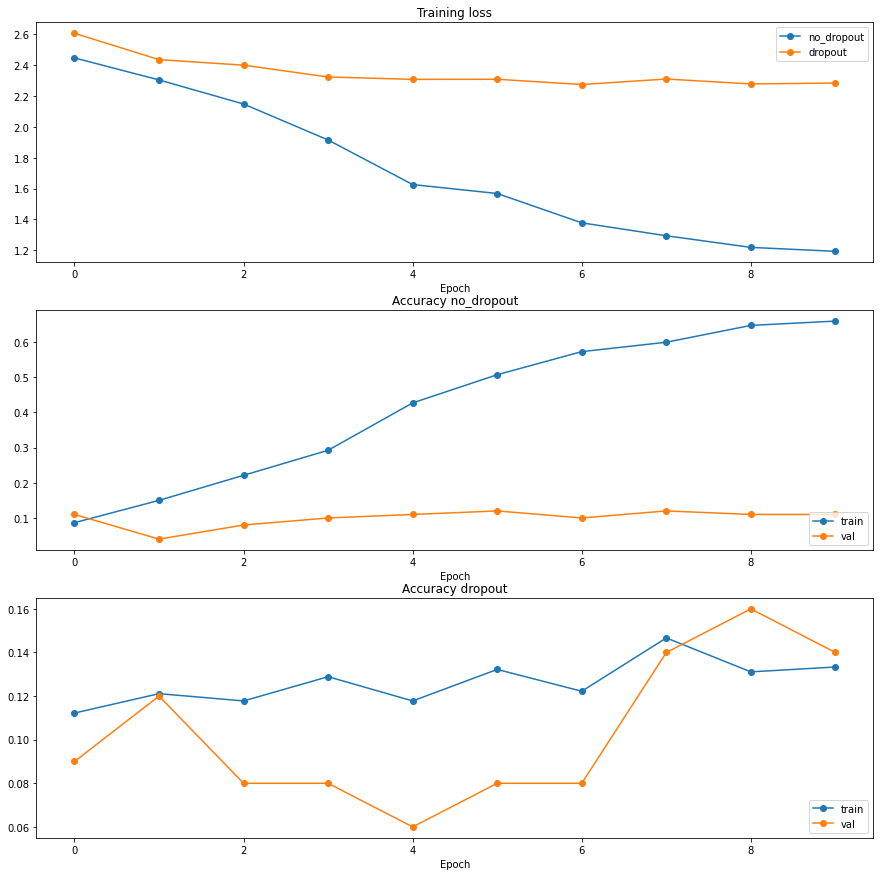

In [0]:
# Dropout checking

dropouts = [0.2,0.2,0.2,0.1,0.1]

print('w/o dropout:')
no_dropout_model = FCNet_TF(input_dim=D, hidden_dims=[H1,H2,H3,H4,H5], num_classes=C, dropouts=None)
no_dropout_history = train(no_dropout_model, data, num_epochs=epochs, lr=lr)

print('\nwith droput:')
dropout_model = FCNet_TF(input_dim=D, hidden_dims=[H1,H2,H3,H4,H5], num_classes=C, dropouts=dropouts)
dropout_history = train(dropout_model, data, num_epochs=epochs, lr=lr)

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.plot(no_dropout_history.history['loss'], '-o', label='no_dropout')
plt.plot(dropout_history.history['loss'], '-o', label='dropout')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.title('Accuracy no_dropout')
plt.plot(no_dropout_history.history['accuracy'], '-o', label='train')
plt.plot(no_dropout_history.history['val_accuracy'], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(3, 1, 3)
plt.title('Accuracy dropout')
plt.plot(dropout_history.history['accuracy'], '-o', label='train')
plt.plot(dropout_history.history['val_accuracy'], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 15)
plt.show()